In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model

from scipy import signal

# Standard process in data science
!['CRISP_DM'](../reports/figures/CRISP_DM.png)

# Apply groupby on large data set

In [2]:
pd_data=pd.read_csv('../data/processed/COVID_relational_confirmed.csv', sep=';',parse_dates=[0])
pd_data=pd_data.sort_values('date',ascending=True).reset_index(drop=True).copy()
pd_data.tail()

,date,state,country,confirmed
56653,2020-08-21,no,Barbados,157
56654,2020-08-21,no,Belarus,70111
56655,2020-08-21,no,Belgium,80894
56656,2020-08-21,no,Albania,8119
56657,2020-08-21,no,Zimbabwe,5815


## Doubling Rate (DR) calculation 

First we will take test dataset for limited countries and apply different method for doubling rate calculation

In [3]:
test_data=pd_data[((pd_data['country']=='US') | 
                   (pd_data['country']=='Germany')) & 
                  (pd_data['date']>'2020-03-20')]

In [4]:
test_data.groupby(['country']).agg(np.max)

,date,state,confirmed
country,,,
Germany,2020-08-21,no,233029
US,2020-08-21,no,5622540


### Methods for calculation of DR

In [5]:
reg = linear_model.LinearRegression(fit_intercept=True)
# Method 1: regression
def get_doubling_time_via_regression(in_array):
    ''' Use a linear regression to approximate the doubling rate'''

    y = np.array(in_array)
    X = np.arange(-1,2).reshape(-1, 1)

    assert len(in_array)==3
    reg.fit(X,y)
    intercept=reg.intercept_
    slope=reg.coef_

    return intercept/slope

# Method 2: Rolling method with regression data
def rolling_reg(df_input,col='confirmed'):
    ''' Doubling rate calculation with rolling function of pandas DataFrame'''
    ''' return is single series (mandatory for group by apply)'''
    days_back=3 # window length
    result=df_input[col].rolling(
                window=days_back,
                min_periods=days_back).apply(get_doubling_time_via_regression,raw=False)
    return result

In [6]:
test_data[['state','country','confirmed']].groupby(['state','country']).apply(rolling_reg,'confirmed')

state  country       
no     Germany  15737           NaN
                16002           NaN
                16268      7.417994
                16534      7.142035
                16800      8.012983
                            ...    
       US       55411    139.992250
                55677    137.401816
                55957    119.859707
                56210    120.937005
                56476    120.268425
Name: confirmed, Length: 308, dtype: float64

## Apply DR to large data

In [7]:
pd_DR=pd_data[['state','country','confirmed']].groupby(['state','country']).apply(rolling_reg,'confirmed').reset_index()

pd_DR=pd_DR.rename(columns={'confirmed':'confirmed_DR',
                            'level_2':'index'})

pd_DR.head()

,state,country,index,confirmed_DR
0,Alberta,Canada,0,NaN
1,Alberta,Canada,465,NaN
2,Alberta,Canada,701,NaN
3,Alberta,Canada,998,NaN
4,Alberta,Canada,1231,NaN


## Merge DR with main dataframe

In [8]:
pd_data=pd_data.reset_index()
pd_data.head()

,index,date,state,country,confirmed
0,0,2020-01-22,Alberta,Canada,0
1,1,2020-01-22,no,"Korea, South",1
2,2,2020-01-22,no,Kosovo,0
3,3,2020-01-22,no,Kuwait,0
4,4,2020-01-22,no,Kyrgyzstan,0


In [9]:
pd_large=pd.merge(pd_data, pd_DR[['index','confirmed_DR']], on=['index'], how='left')
pd_large.head()

,index,date,state,country,confirmed,confirmed_DR
0,0,2020-01-22,Alberta,Canada,0,NaN
1,1,2020-01-22,no,"Korea, South",1,NaN
2,2,2020-01-22,no,Kosovo,0,NaN
3,3,2020-01-22,no,Kuwait,0,NaN
4,4,2020-01-22,no,Kyrgyzstan,0,NaN


## Visulization

In [10]:
def plot_DR_cases(df, country):
    fig, ax1 = plt.subplots(figsize=(16,5))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Doubling rate', color='blue')
    ax1.plot(df[df['country']==country]['date'],
             df[df['country']==country]['confirmed_DR'], color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()  

    ax2.set_ylabel('Confirmed cases', color='red')  
    ax2.plot(df[df['country']==country]['date'],
             df[df['country']==country]['confirmed'], color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.set_title('Country: ' + country)
    fig.tight_layout()  

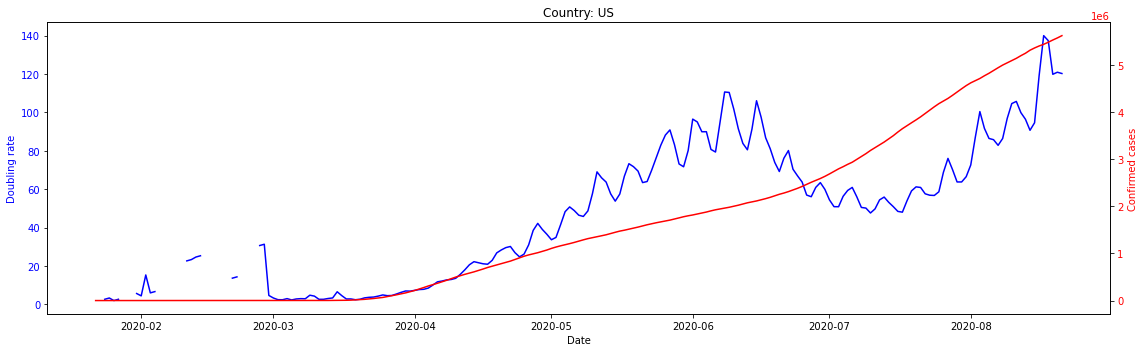

In [11]:
plot_DR_cases(pd_large, 'US')

## Apply filter for smooth data

In [12]:
def savgol_filter(df_input,column='confirmed',window=5):
    ''' Savgol Filter which can be used in groupby apply function 
        it ensures that the data structure is kept'''
    window=5, 
    degree=1
    df_result=df_input
    
    filter_in=df_input[column].fillna(0) # attention with the neutral element here
    
    result=signal.savgol_filter(np.array(filter_in),
                           5, # window size used for filtering
                           1)
    df_result[column+'_filtered']=result
    return df_result

In [13]:
pd_filtered=pd_data[['state','country','confirmed']].groupby(['state','country']).apply(savgol_filter).reset_index()

In [14]:
pd_large_filtered=pd.merge(pd_large,pd_filtered[['index','confirmed_filtered']],on=['index'],how='left')
pd_large.head()

,index,date,state,country,confirmed,confirmed_DR
0,0,2020-01-22,Alberta,Canada,0,NaN
1,1,2020-01-22,no,"Korea, South",1,NaN
2,2,2020-01-22,no,Kosovo,0,NaN
3,3,2020-01-22,no,Kuwait,0,NaN
4,4,2020-01-22,no,Kyrgyzstan,0,NaN


In [15]:
# calculate doubling rate for filtered data
pd_DR_filtered=pd_large_filtered[['state','country','confirmed_filtered']].groupby(['state','country']).apply(rolling_reg,'confirmed_filtered').reset_index()
pd_DR_filtered=pd_DR_filtered.rename(columns={'confirmed_filtered':'confirmed_filtered_DR', 'level_2':'index'})

pd_DR_filtered.tail()

,state,country,index,confirmed_filtered_DR
56653,no,Zimbabwe,55460,54.757039
56654,no,Zimbabwe,55658,46.956725
56655,no,Zimbabwe,55955,48.673197
56656,no,Zimbabwe,56190,44.892728
56657,no,Zimbabwe,56657,41.389573


In [16]:
# merge large data with filtered doubling rate
pd_large_filtered=pd.merge(pd_large_filtered,pd_DR_filtered[['index','confirmed_filtered_DR']],on=['index'],how='left')
pd_large_filtered.tail()

,index,date,state,country,confirmed,confirmed_DR,confirmed_filtered,confirmed_filtered_DR
56653,56653,2020-08-21,no,Barbados,157,156.000000,157.2,119.923077
56654,56654,2020-08-21,no,Belarus,70111,451.316129,70089.0,529.575322
56655,56655,2020-08-21,no,Belgium,80894,113.333804,80796.6,133.638560
56656,56656,2020-08-21,no,Albania,8119,51.895765,8120.8,51.291050
56657,56657,2020-08-21,no,Zimbabwe,5815,66.678295,5854.0,41.389573


In [17]:
# take only data where number of cases is atleast 100
mask=pd_large_filtered['confirmed']>100
pd_large_filtered['confirmed_filtered_DR']=pd_large_filtered['confirmed_filtered_DR'].where(mask, other=np.NaN) 

In [18]:
# export data
pd_large_filtered.to_csv('../data/processed/COVID_final_set.csv',sep=';',index=False)